# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


[2023-07-19 08:58:39,331][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-19 08:58:39,377][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [2]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
import numpy as np
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [3]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [4]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FJ4IJOQ,scan9FJ4IJOQ,1,1,1,25200,0,666.75,20448.5,23697.1,29.9649,1,63.2052,0.712867,None,840.984,bench2p


In [5]:
# trial.TrialType().delete()
# trial.Trial.delete()
# trial.TrialEvent.delete()

[2023-07-19 08:58:45,128][INFO]: Deleting 0 rows from `tobiasr_trial`.`#trial_type`
[2023-07-19 08:58:45,129][WARNING]: Nothing to delete.


0

In [66]:
scansi = "scan9FJ4IJOQ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]



In [67]:
scan.ScanInfo() & scan_key

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1
sess9FJ4IJOQ,scan9FJ4IJOQ,1,1,1,25200,0,666.75,20448.5,23697.1,29.9649,1,63.2052,0.712867,None,840.984,bench2p


In [68]:
stims_per_trial = len(set((event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")))
all_stims = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")
trial_stims = {x: list(all_stims).count(x) for x in all_stims}
trials = set([list(all_stims).count(x) for x in all_stims])
stims = len
trial_stims
trials

{10}

In [69]:
trial_start_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
trial_end_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] 
trial_event_name = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")[0].split(':')[0]
# trial.TrialType().insert1({'trial_type': trial_event_name, 'trial_type_description': ''}, skip_duplicates=True) 

In [73]:
trial.TrialType()

trial_type,trial_type_description
Moving_Gratings,Stimulus nomenclature: Type; Class; Azimuth; Elevation; Size; Orientation; Spatial Frequency; Temporal Frequency


In [70]:
trial_start_edges

array([  6.755 ,  90.4189, 174.433 , 258.452 , 342.476 , 426.483 ,
       510.504 , 594.515 , 678.56  , 762.549 ])

In [71]:
trial_end_edges

array([ 86.903, 170.622, 254.63 , 338.649, 422.663, 506.681, 590.696,
       674.719, 758.74 , 842.745])

In [72]:
event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")

# Ingestions!

In [ ]:

# ibe.ingest_aux(sessi,scansi, verbose=True, aux_setup_type="bench2p")
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr)     

# example queries

In [23]:
scansi = "scan9FJ4IJOQ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

(event.Event & scan_key & f'event_type LIKE "%;%"').fetch(format = "frame", order_by = "event_start_time")

event_end_time
session_id   scan_id      event_type                                         event_start_time                
sess9FJ4IJOQ scan9FJ4IJOQ Moving_Gratings:60;Moving_Gratings;0;10;50:50;6... 6.7550                    9.7144
                          Moving_Gratings:90;Moving_Gratings;0;10;50:50;9... 13.7706                  16.7314
                          Moving_Gratings:300;Moving_Gratings;0;10;50:50;... 20.7888                  23.7563
                          Moving_Gratings:180;Moving_Gratings;0;10;50:50;... 27.8148                  30.7643
                          Moving_Gratings:120;Moving_Gratings;0;10;50:50;... 34.8169                  37.7830
...                                                                                                       ...
                          Moving_Gratings:180;Moving_Gratings;0;10;50:50;... 811.6720                814.6790
                          Moving_Gratings:240;Moving_Gratings;0;10;50:50;... 818.6810                821.6950
                          Moving_Gratings:300;Moving_Gratings;0;10;50:50;... 825.6970                828.7130
                          Moving_Gratings:60;Moving_Gratings;0;10;50:50;6... 832.7170                835.7290
                          Moving_Gratings:210;Moving_Gratings;0;10;50:50;... 839.7320                842.7450

[120 rows x 1 columns]

In [74]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus

scansi = "scan9FJ4IJOQ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 

orientation = 180

trialnum = 2

dataframe = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch(format = "frame")
dataframe

event_end_time
session_id   scan_id      event_type                                         event_start_time trial_id                
sess9FJ4IJOQ scan9FJ4IJOQ Moving_Gratings:180;Moving_Gratings;0;10;50:50;... 27.8148          1                30.7643
                                                                             153.5660         2               156.5810

In [75]:
# example: get stimulus onsets and offsets of certain trials fro a single stimulus
temporal_freq = (event.Event * trial.TrialEvent & scan_key & f'event_type LIKE "%{orientation}%"' & f"trial_id <= {trialnum}").fetch("event_type")[0].split(";")[7]

print(temporal_freq)

3


In [18]:
trialnum = 1 # 1-indexed!
TrialEvent_query_keys = (event.Event * trial.Trial & scan_key & f'event_type LIKE "%;%"' & f'event_start_time <= "{trial_end_edges[trialnum-1]}"' & f'event_end_time >= "{trial_start_edges[trialnum-1]}"' & f'trial_id= "{trialnum}"').fetch(format = "frame", order_by = "event_start_time")

In [19]:
TrialEvent_query_keys

event_end_time   
session_id   scan_id      event_type                                         event_start_time trial_id                   
sess9FJ4IJOQ scan9FJ4IJOQ Moving_Gratings:60;Moving_Gratings;0;10;50:50;6... 6.7550           1                 9.7144  \
                          Moving_Gratings:90;Moving_Gratings;0;10;50:50;9... 13.7706          1                16.7314   
                          Moving_Gratings:300;Moving_Gratings;0;10;50:50;... 20.7888          1                23.7563   
                          Moving_Gratings:180;Moving_Gratings;0;10;50:50;... 27.8148          1                30.7643   
                          Moving_Gratings:120;Moving_Gratings;0;10;50:50;... 34.8169          1                37.7830   
                          Moving_Gratings:30;Moving_Gratings;0;10;50:50;3... 41.8437          1                44.7977   
                          Moving_Gratings:270;Moving_Gratings;0;10;50:50;... 48.8462          1                51.8144   
                          Moving_Gratings:210;Moving_Gratings;0;10;50:50;... 55.8713          1                58.8308   
                          Moving_Gratings:330;Moving_Gratings;0;10;50:50;... 62.8993          1                65.8474   
                          Moving_Gratings:240;Moving_Gratings;0;10;50:50;... 69.9062          1                72.8706   
                          Moving_Gratings:0;Moving_Gratings;0;10;50:50;0;... 76.9119          1                79.8848   
                          Moving_Gratings:150;Moving_Gratings;0;10;50:50;... 83.9371          1                86.9030   

                                                                                                             trial_type   
session_id   scan_id      event_type                                         event_start_time trial_id                    
sess9FJ4IJOQ scan9FJ4IJOQ Moving_Gratings:60;Moving_Gratings;0;10;50:50;6... 6.7550           1         Moving_Gratings  \
                          Moving_Gratings:90;Moving_Gratings;0;10;50:50;9... 13.7706          1         Moving_Gratings   
                          Moving_Gratings:300;Moving_Gratings;0;10;50:50;... 20.7888          1         Moving_Gratings   
                          Moving_Gratings:180;Moving_Gratings;0;10;50:50;... 27.8148          1         Moving_Gratings   
                          Moving_Gratings:120;Moving_Gratings;0;10;50:50;... 34.8169          1         Moving_Gratings   
                          Moving_Gratings:30;Moving_Gratings;0;10;50:50;3... 41.8437          1         Moving_Gratings   
                          Moving_Gratings:270;Moving_Gratings;0;10;50:50;... 48.8462          1         Moving_Gratings   
                          Moving_Gratings:210;Moving_Gratings;0;10;50:50;... 55.8713          1         Moving_Gratings   
                          Moving_Gratings:330;Moving_Gratings;0;10;50:50;... 62.8993          1         Moving_Gratings   
                          Moving_Gratings:240;Moving_Gratings;0;10;50:50;... 69.9062          1         Moving_Gratings   
                          Moving_Gratings:0;Moving_Gratings;0;10;50:50;0;... 76.9119          1         Moving_Gratings   
                          Moving_Gratings:150;Moving_Gratings;0;10;50:50;... 83.9371          1         Moving_Gratings   

                                                                                                        trial_start_time   
session_id   scan_id      event_type                                         event_start_time trial_id                     
sess9FJ4IJOQ scan9FJ4IJOQ Moving_Gratings:60;Moving_Gratings;0;10;50:50;6... 6.7550           1                    6.755  \
                          Moving_Gratings:90;Moving_Gratings;0;10;50:50;9... 13.7706          1                    6.755   
                          Moving_Gratings:300;Moving_Gratings;0;10;50:50;... 20.7888          1                    6.755   
                          Moving_Gratings:180;Moving

In [ ]:
len(TrialEvent_query_keys)

In [ ]:
trial.TrialEvent.insert(TrialEvent_query_keys,  allow_direct_insert=True, skip_duplicates=True, ignore_extra_fields=True)

In [ ]:
trial_start_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] 
trial_end_edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial]     
    
trial_event_name = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_type")[0].split(':')[0]
trial.TrialType().insert1({'trial_type': trial_event_name, 'trial_type_description': ''}, skip_duplicates=True)


In [ ]:
for trialnum in enumerate(trial_start_edges):
    trial.Trial.insert1({'session_id': sessi, 'scan_id': scansi, 'trial_id': trialnum[0], 'trial_type': trial_event_name, 'trial_start_time': trial_start_edges[trialnum[0]], 'trial_stop_time': trial_end_edges[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)
                
    event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
    event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")
    

In [ ]:
event_names

In [ ]:
                trial.TrialEvent.insert1({'session_id': session_key, 'scan_id': scan_key, 'trial_id': trialnum[0], 'event_type': event_single, 'event_start_time': event_onsets[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)

In [ ]:
event_names = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_type",order_by = "event_start_time")
event_onsets = (event.Event & scan_key & 'event_type LIKE "%;%"' & f"event_end_time < {trial_end_edges[0]}").fetch("event_start_time",order_by = "event_start_time")


In [ ]:
scan_key

In [ ]:
 trial.TrialEvent.insert1({'session_id': sessi, 'scan_id': scansi, 'trial_id': 0, 'trial_type': trial_event_name})

In [ ]:
trial.TrialEvent.insert1({'session_id': session_key, 'scan_id': scan_key, 'trial_id': trialnum[0], 'trial_type': trial_event_name, 'trial_start_time': trial_start_edges[trialnum[0]], 'trial_stop_time': trial_end_edges[trialnum[0]]},  allow_direct_insert=True, skip_duplicates=True)

In [17]:
auxpath = (event.BehaviorRecording.File() & scan_key).fetch('filepath')
print(auxpath)

['/datajoint-data/data/tobiasr/LE_ROS-1518_2023-07-18_scan9FJ4IJOQ_sess9FJ4IJOQ/scan9FJ4IJOQ_LE_ROS-test_0003.h5']


In [18]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
aux_setup_typestr

'bench2p'

In [19]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )

/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [20]:
 sweep = [x for x in curr_file.keys() if 'sweep' in x][0]

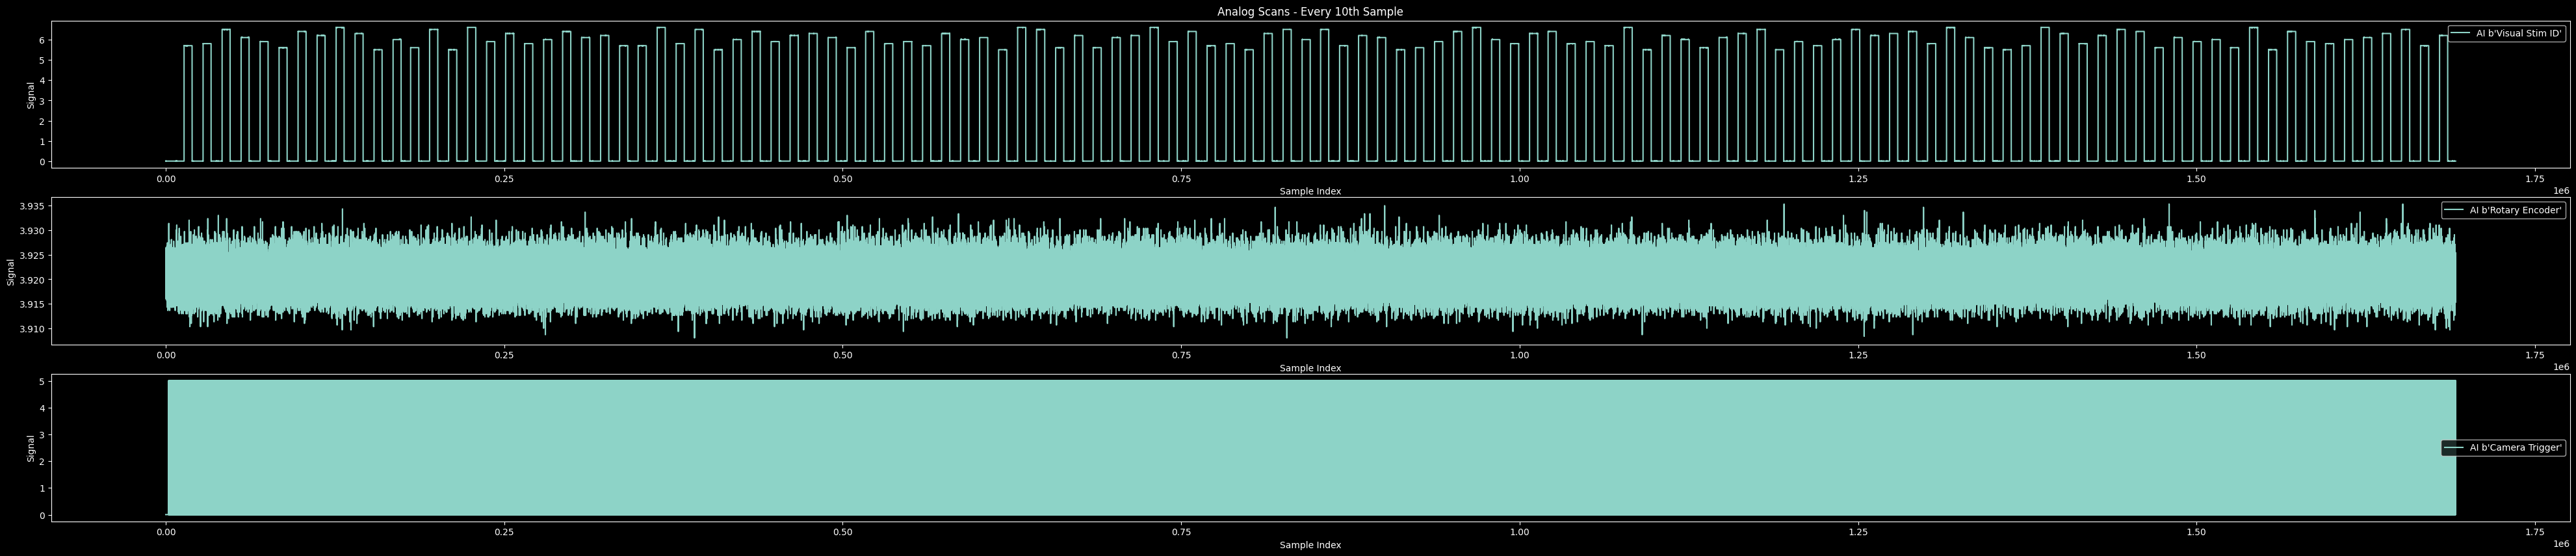

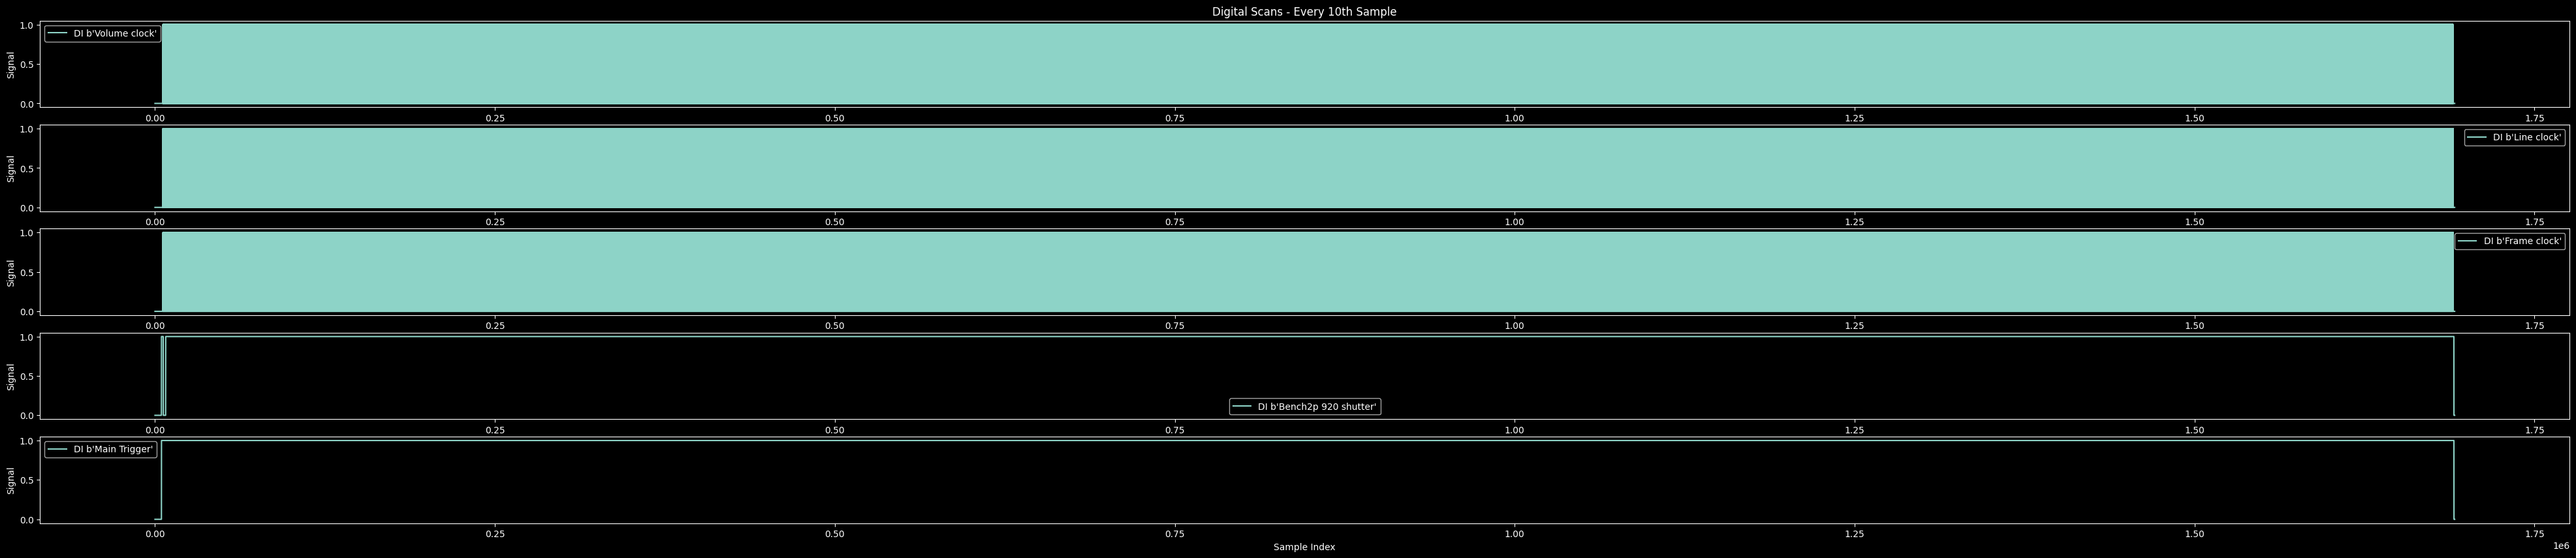

In [21]:
import numpy as np

analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_labels = curr_file['header']['DIChannelNames']
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], np.shape(digital_labels)[0])
step = 10

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=analog_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=digital_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Digital Scans - Every {step}th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
plt.show()


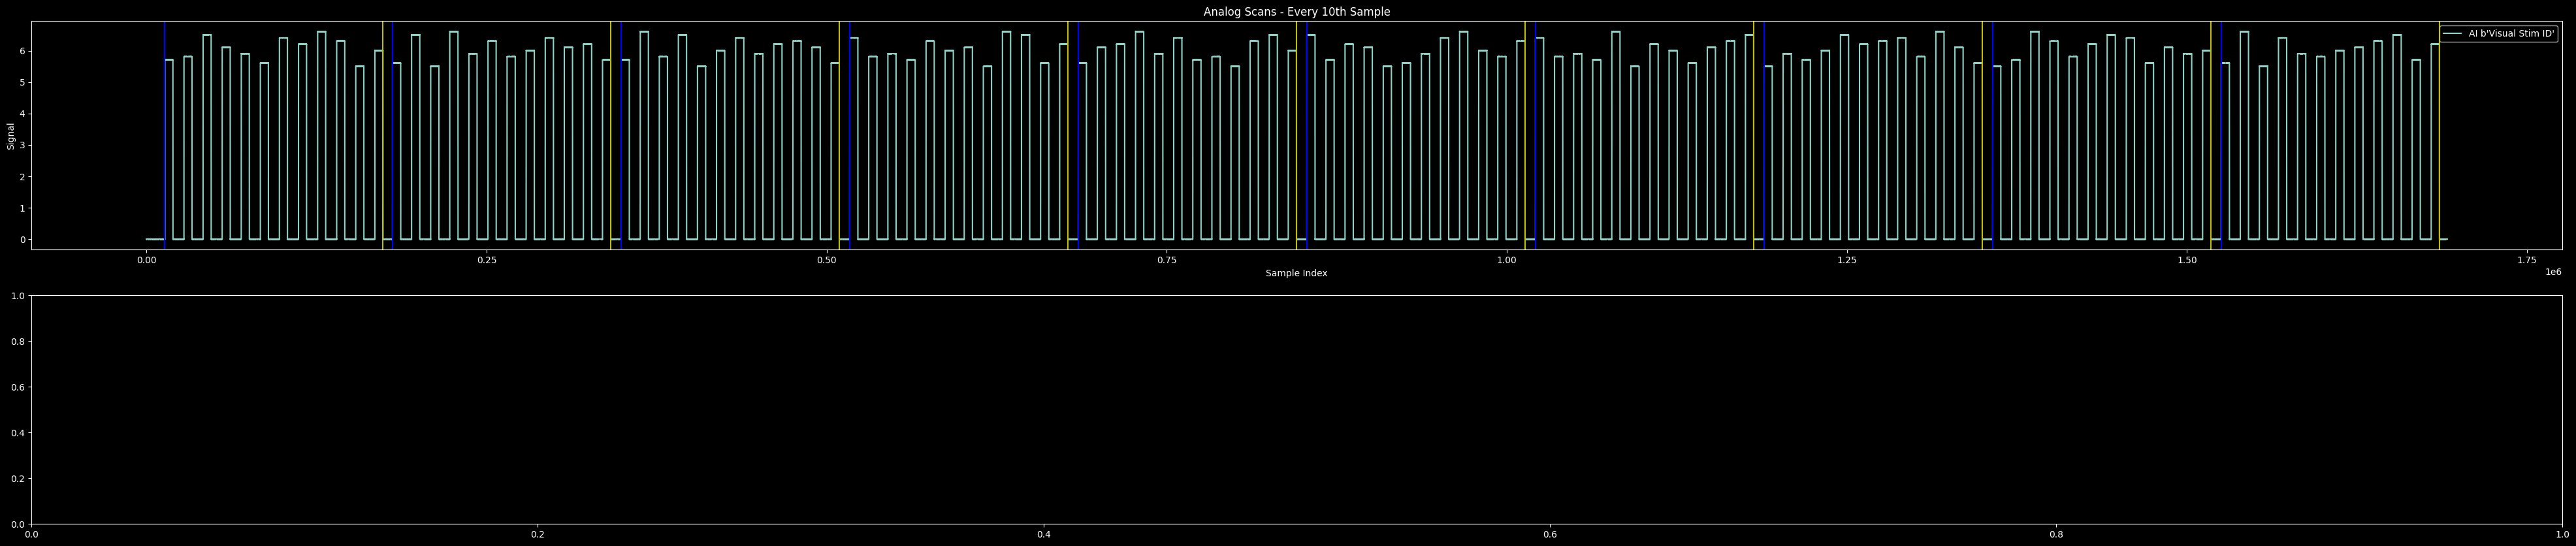

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(50, 10))
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
# for i in range(analog_scans.shape[0]):
i = 0
axes[i].plot(np.abs(analog_scans[i][::step]), label=f"AI {analog_labels[i]}")
axes[i].legend()
axes[i].set_xlabel("Sample Index")
axes[i].set_ylabel("Signal")


if i == 0:
     onsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time') * sr / step
     offsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_end_time') * sr / step
     edges = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_start_time",order_by = "event_start_time")[::stims_per_trial] * sr / step
     edgesoff = (event.Event & scan_key & 'event_type LIKE "%;%"').fetch("event_end_time",order_by = "event_end_time")[stims_per_trial-1::stims_per_trial] * sr / step
     for xc in onsets:
          axes[i].axvline(x=xc, color = 'r')
     for xc in offsets:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'w')
     for xc in edges:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'b')
     for xc in edgesoff:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'y')

In [ ]:
ibe.get_timestamps(np.abs(analog_scans[i]), sr, 1)

In [ ]:
event.Event & scan_key

In [ ]:
(event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time')
# auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')

In [ ]:
dj.Diagram(trial) + dj.Diagram(event) +100


In [ ]:
surgery

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)


In [ ]:
scan.Scan()

In [ ]:
event.AlignmentEvent()

In [ ]:
trial.Trial()

In [ ]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()